#Assignment 06: Computer Vision Applications
To train semantic segmentation models on the `Satellite buildings` images dataset.



**Submission Deadline: Thursday, 2/24/2022 at 3:00 PM**

**Requirements:**

1. Import all necessary libraries for the semantic segmentation project.
2. Download the dataset (the link is provided below).
3. Create a function that convert the images path into dataframe(make sure that the images and their masks are matching). 
4. Make sure to convert the mask into one hot vector.
5. Split the dataset into train and test dateset (test dataset should be 10% of the total dataset).
6. Create data pipeline with data augmentation.
    1. Read images using tensorflow.
    2. Make sure the pixels values are scaled between (`0-1`).
    3. Resize the images to (224,224).
    4. Apply multiple image augmentation on the data (make sure that the image augmentation is reflected on its mask).
    5. Make sure the augmentation image pixels are scaled between (`0-1`). 
7. Plot the images.
8. Build Autoencoder model.

9. Build UNet model.<br>

Find relevant links
[Dataset](https://www.kaggle.com/hyyyrwang/buildings-dataset)


# 1- Import all necessary libraries for the semantic segmentation project

In [1]:
# import python libraries for the project
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import random
import numpy as np
import os
import glob
import tqdm
from sklearn import model_selection


# 2- Download the dataset

In [2]:
# download the required dataset from kaggle 

! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json


! kaggle datasets download -d hyyyrwang/buildings-dataset

 99% 837M/842M [00:08<00:00, 91.4MB/s]
100% 842M/842M [00:09<00:00, 97.7MB/s]


In [3]:
! unzip /content/buildings-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: src/T1886.png           
  inflating: src/T1887.png           
  inflating: src/T1888.png           
  inflating: src/T1889.png           
  inflating: src/T189.png            
  inflating: src/T1890.png           
  inflating: src/T1891.png           
  inflating: src/T1892.png           
  inflating: src/T1893.png           
  inflating: src/T1894.png           
  inflating: src/T1895.png           
  inflating: src/T1896.png           
  inflating: src/T1897.png           
  inflating: src/T1898.png           
  inflating: src/T1899.png           
  inflating: src/T19.png             
  inflating: src/T190.png            
  inflating: src/T1900.png           
  inflating: src/T1901.png           
  inflating: src/T1902.png           
  inflating: src/T1903.png           
  inflating: src/T1904.png           
  inflating: src/T1905.png           
  inflating: src/T1906.png           
  inflating: src/T1907.png           

# 3- Create a function that converts the images paths into a dataframe(make sure that the images and their masks are matching)

In [4]:
# create a function to get the folder path that contains the images 
# return a pandas dataframe that have the input images with there masks 

def create_dataset():
  images=sorted(glob.glob('/content/src/*.png'))
  masks=sorted(glob.glob('/content/label/*.png'))
  data={'images':images,'masks':masks}
  return pd.DataFrame(data)



data=create_dataset()


In [5]:
data

,images,masks
0,/content/src/S001.png,/content/label/S001.png
1,/content/src/S002.png,/content/label/S002.png
2,/content/src/S003.png,/content/label/S003.png
3,/content/src/S004.png,/content/label/S004.png
4,/content/src/S005.png,/content/label/S005.png
...,...,...
6025,/content/src/W995.png,/content/label/W995.png
6026,/content/src/W996.png,/content/label/W996.png
6027,/content/src/W997.png,/content/label/W997.png
6028,/content/src/W998.png,/content/label/W998.png


#4-split the datasets

In [6]:
#split the data to train and test
x_train,x_test,y_train,y_test=model_selection.train_test_split(data.images,
                                                               data.masks,test_size=0.1,
                                                               random_state=42)

In [7]:
# check the shape of the following (x_train, y_train and x_test, y_test)
print('x_train :', x_train.shape)
print('y_train :',y_train.shape)
print('x_test :' ,x_test.shape)
print('y_test :' ,y_test.shape)

x_train : (5427,)
y_train : (5427,)
x_test : (603,)
y_test : (603,)


In [8]:
x_train

240      /content/src/T116.png
1351     /content/src/T216.png
4591    /content/src/W1025.png
2323    /content/src/T3034.png
1867    /content/src/T2624.png
                 ...          
3772    /content/src/T4339.png
5191     /content/src/W243.png
5226     /content/src/W275.png
5390     /content/src/W422.png
860     /content/src/T1718.png
Name: images, Length: 5427, dtype: object

In [9]:
x_test

1870    /content/src/T2627.png
5922     /content/src/W901.png
1328    /content/src/T2139.png
5082    /content/src/W1468.png
3411    /content/src/T4013.png
                 ...          
1022    /content/src/T1864.png
3800    /content/src/T4364.png
3932    /content/src/T4483.png
4560       /content/src/W0.png
4515     /content/src/T959.png
Name: images, Length: 603, dtype: object

In [10]:
def read_image(x,y):
  # Read and decode an image file to a uint8 tensor

  x=tf.io.read_file(x)#reads the entire contents of the input filename
  x=tf.image.decode_png(x,channels=3)#detects whether an image
  x=tf.image.convert_image_dtype(x,tf.float32)
  x=tf.image.resize(x,(256,256))
  x=tf.clip_by_value(x,clip_value_min=0,clip_value_max=1)

  y=tf.io.read_file(y)
  y=tf.image.decode_png(y,channels=1)
  y=tf.image.resize(y,(256,256),method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  y=tf.clip_by_value(y,clip_value_min=0,clip_value_max=1)
  y=tf.reshape(y,(256,256))
  y=tf.cast(y,tf.int32)
  y=tf.one_hot(y,2)
  return x,y

In [11]:
def agu_create(x,y):
  seed=np.random.randint(low=0,high=100,size=1)
  tf.compat.v1.set_random_seed(seed)
  x = tf.image.random_flip_left_right(x,seed=seed[0])
  x = tf.image.random_brightness(x, max_delta=32.0 / 255.0)
  x = tf.image.random_saturation(x, lower=0.5, upper=1.5)
  #Make sure the image is still between [0, 1]
  x = tf.clip_by_value(x, 0, 1)

  y=tf.argmax(y,axis=-1)
  y=tf.reshape(y,shape=(256,256,1))
  y=tf.image.random_flip_left_right(y,seed=seed[0])
  y=tf.clip_by_value(y,0,1)
  y=tf.reshape(y,shape=(256,256))
  y=tf.cast(y,tf.int32)
  y=tf.one_hot(y,2)
  return x,y

# 6- Create data pipeline with data augmentation

Notes:<br>
1. Read images using tensorflow.
2. Make sure the pixels values are scaled between (0-1).
3. Resize the images to (224,224).
4. Apply multiple image augmentation on the data(make sure that the image augmentation is reflected on its mask).
5. Make sure the augmentation image pixels are scaled between (0-1).

In [12]:
#Create the data pipeline
def dataset_create(x,y,training):
  data=tf.data.Dataset.from_tensor_slices((x,y))
  data=data.shuffle(1028,reshuffle_each_iteration=True)
  data=data.map(read_image,num_parallel_calls=tf.data.AUTOTUNE)
  if training:

    data=data.map(agu_create,num_parallel_calls=tf.data.AUTOTUNE)
  data=data.batch(32)
  data=data.prefetch(tf.data.AUTOTUNE)
  return data

train_dataset=dataset_create(x_train,y_train,training=True)

test_dataset=dataset_create(x_test,y_test,training=False)   

  



# 7- Plot the images

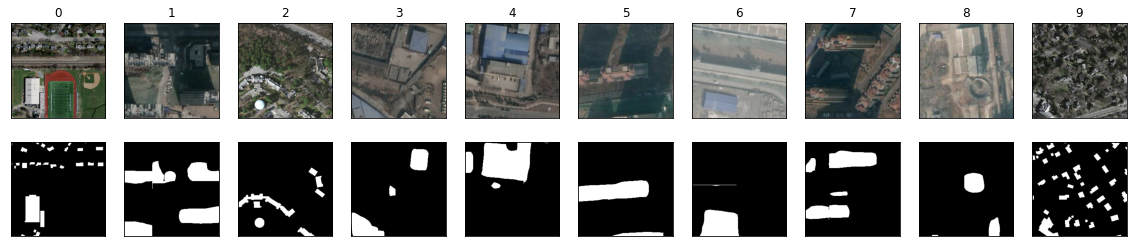

In [13]:
n = 10
plt.figure(figsize=(20, 4))

for x,y in train_dataset.take(1):



    for i in range(n):
        ax=plt.subplot(2, n, i + 1)
        plt.title(f"{i}")
        plt.imshow(tf.squeeze(x[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

    
        bx=plt.subplot(2, n, n+i + 1)

    
        
        plt.imshow(tf.squeeze(tf.argmax(y[i],-1)))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)

        


plt.show()

8- Build Autoencoder model

# 8- Build Autoencoder model

In [56]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Encoder,self).__init__()

        #block 1 
     
        self.Conv_1=tf.keras.layers.Conv2D(filters=16,kernel_size=(3,3),strides=(1,1),padding='same',use_bias=False)
        self.BN_1=tf.keras.layers.BatchNormalization()
        #block 2 
        self.Conv_2=tf.keras.layers.Conv2D(filters=32,kernel_size=(3,3),strides=(2,2),padding='same',use_bias=False)
        self.BN_2=tf.keras.layers.BatchNormalization()
        #block 3
        self.Conv_3=tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',use_bias=False)
        self.BN_3=tf.keras.layers.BatchNormalization()
        #block 4
        self.Conv_4=tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),strides=(2,2),padding='same',use_bias=False)
        self.BN_4=tf.keras.layers.BatchNormalization()
        #block 5
        self.Conv_5=tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',use_bias=False)
        self.BN_5=tf.keras.layers.BatchNormalization()

    def call(self,x):
        #block 1
        x=self.Conv_1(x)
        x=self.BN_1(x)
        x=tf.nn.leaky_relu(x)
        #block 2
        x=self.Conv_2(x)
        x=self.BN_2(x)
        x=tf.nn.leaky_relu(x)
        #block 3
        x=self.Conv_3(x)
        x=self.BN_3(x)
        x=tf.nn.leaky_relu(x)
        #block 4
        x=self.Conv_4(x)
        x=self.BN_4(x)
        x=tf.nn.leaky_relu(x)
        #block 5
        x=self.Conv_5(x)
        x=self.BN_5(x)
        x=tf.nn.leaky_relu(x)


        return x 

    def build_model(self,dim):
        x=tf.keras.layers.Input(shape=dim)
        return tf.keras.Model(inputs=[x],outputs=[self.call(x)])

encoder=Encoder()
encoder.build_model((256,256,3)).summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 conv2d_63 (Conv2D)          (None, 256, 256, 16)      432       
                                                                 
 batch_normalization_102 (Ba  (None, 256, 256, 16)     64        
 tchNormalization)                                               
                                                                 
 tf.nn.leaky_relu_60 (TFOpLa  (None, 256, 256, 16)     0         
 mbda)                                                           
                                                                 
 conv2d_64 (Conv2D)          (None, 128, 128, 32)      4608      
                                                                 
 batch_normalization_103 (Ba  (None, 128, 128, 32)     128

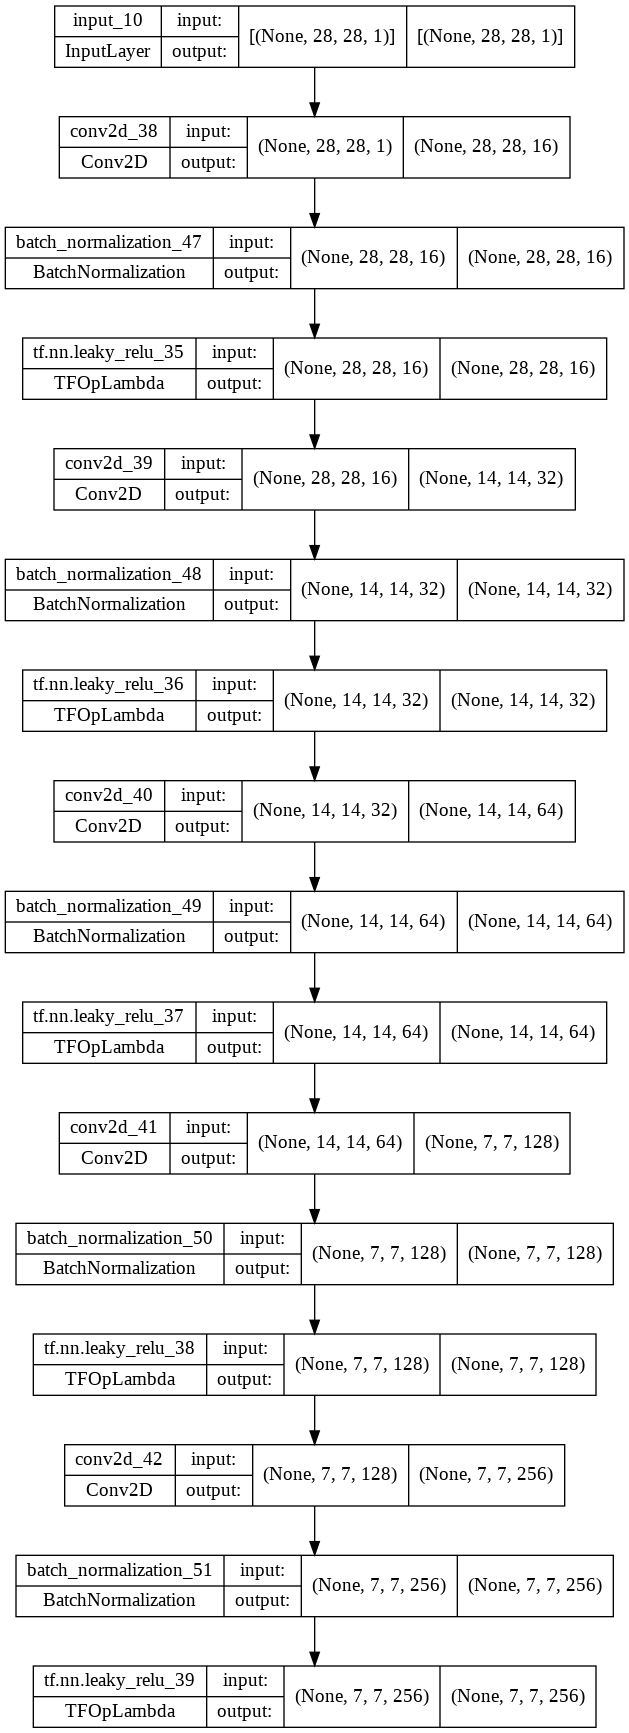

In [42]:

tf.keras.utils.plot_model(encoder.build_model((28,28,1)),show_shapes=True)

In [62]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self):
        super(Decoder,self).__init__()
        #block 1
        
        self.Conv_1=tf.keras.layers.Conv2DTranspose(filters=256,kernel_size=(3,3),strides=(1,1),padding='same',use_bias=False)
        self.BN_1=tf.keras.layers.BatchNormalization()
        #block 2
        self.Conv_2=tf.keras.layers.Conv2DTranspose(filters=128,kernel_size=(3,3),strides=(2,2),padding='same',use_bias=False)
        self.BN_2=tf.keras.layers.BatchNormalization()
        #block 3
        self.Conv_3=tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=(3,3),strides=(1,1),padding='same',use_bias=False)
        self.BN_3=tf.keras.layers.BatchNormalization()
        #block 4
        self.Conv_4=tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=(3,3),strides=(2,2),padding='same',use_bias=False)
        self.BN_4=tf.keras.layers.BatchNormalization()
        #block 5
        self.Conv_5=tf.keras.layers.Conv2DTranspose(filters=16,kernel_size=(3,3),strides=(1,1),padding='same',use_bias=False)
        self.BN_5=tf.keras.layers.BatchNormalization()
        #block 6
        self.Out=tf.keras.layers.Conv2DTranspose(filters=2,kernel_size=(1,1),strides=(1,1))

       
        


    def call(self,x):
        #block 1
        x=self.Conv_1(x)
        x=self.BN_1(x)
        x=tf.nn.leaky_relu(x)
        #block 2

        x=self.Conv_2(x)
        x=self.BN_2(x)
        x=tf.nn.leaky_relu(x)
        #block 3

        x=self.Conv_3(x)
        x=self.BN_3(x)
        x=tf.nn.leaky_relu(x)
        #block 4

        x=self.Conv_4(x)
        x=self.BN_4(x)
        x=tf.nn.leaky_relu(x)
        #block 5
        x=self.Conv_5(x)
        x=self.BN_5(x)
        x=tf.nn.leaky_relu(x)
        #block 6
        
        

        output=self.Out(x)
        output=tf.nn.softmax(output)

        return output

    def build_model(self,dim):
        x=tf.keras.layers.Input(shape=dim)
        return tf.keras.Model(inputs=[x],outputs=[self.call(x)])

dncoder=Decoder()
dncoder.build_model((7,7,256)).summary()


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 7, 7, 256)]       0         
                                                                 
 conv2d_transpose_71 (Conv2D  (None, 7, 7, 256)        589824    
 Transpose)                                                      
                                                                 
 batch_normalization_132 (Ba  (None, 7, 7, 256)        1024      
 tchNormalization)                                               
                                                                 
 tf.nn.leaky_relu_70 (TFOpLa  (None, 7, 7, 256)        0         
 mbda)                                                           
                                                                 
 conv2d_transpose_72 (Conv2D  (None, 14, 14, 128)      294912    
 Transpose)                                               

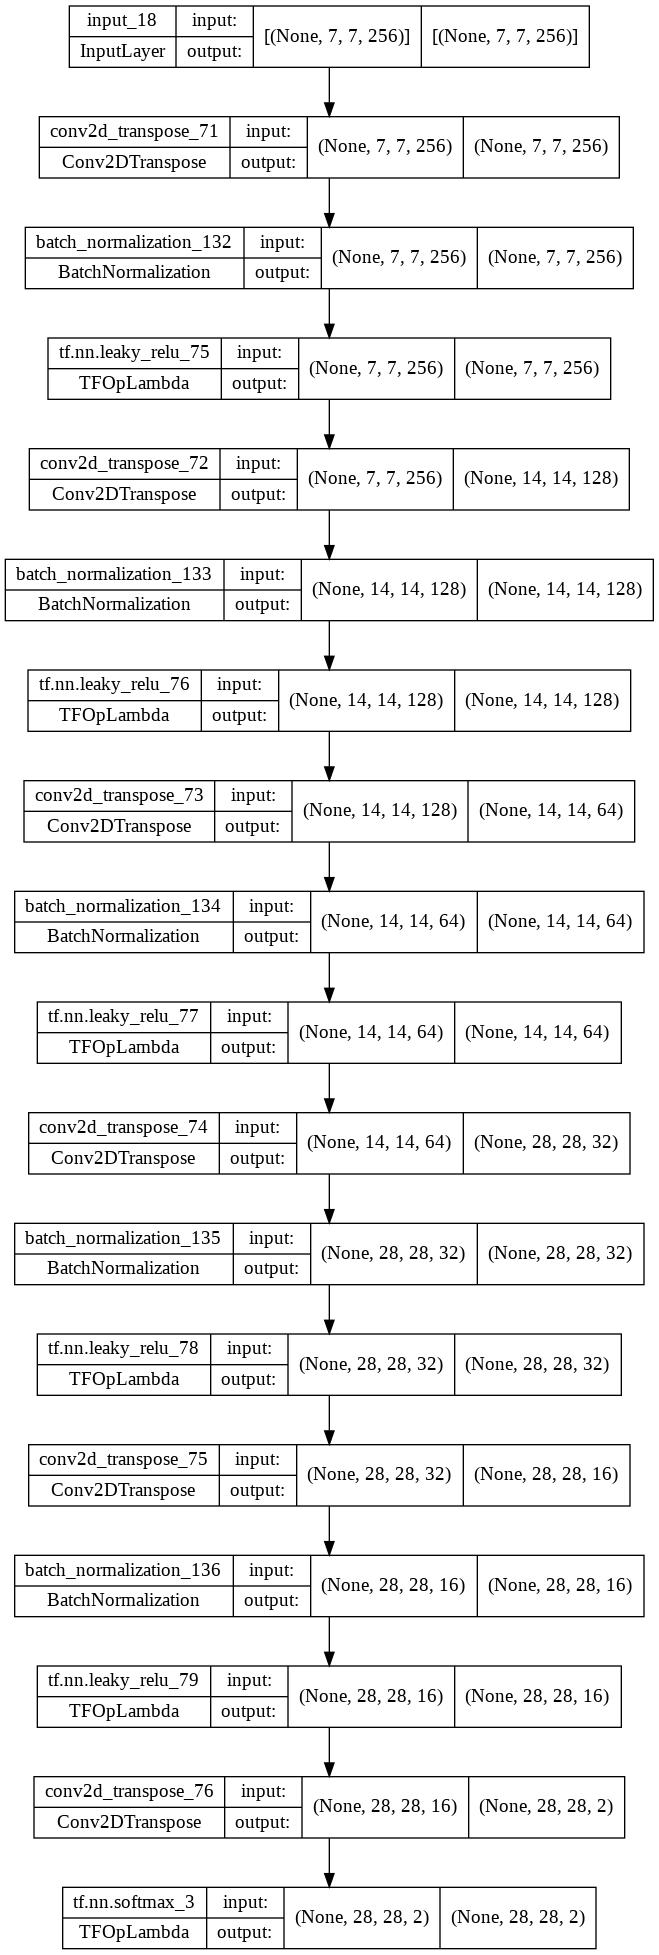

In [63]:
tf.keras.utils.plot_model(dncoder.build_model((7,7,256)),show_shapes=True)

In [64]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder,self).__init__()
        
        self.encoder=Encoder()
      
        self.decoder=Decoder()
    def call(self,x):

      x=self.encoder(x)
      x=self.decoder(x)
      return x

autoencoder=Autoencoder()
autoencoder.build(input_shape=(None,256,256,3))

In [65]:
autoencoder.compile(optimizer='adam', loss=tf.losses.CategoricalCrossentropy())

In [66]:
autoencoder.fit(train_dataset,
                epochs=5,
                validation_data=test_dataset)


Epoch 1/5
170/170 [==============================] - 162s 932ms/step - loss: 0.4099 - val_loss: 0.4431
Epoch 2/5
170/170 [==============================] - 154s 902ms/step - loss: 0.3603 - val_loss: 0.4765
Epoch 3/5
170/170 [==============================] - 153s 896ms/step - loss: 0.3394 - val_loss: 0.4117
Epoch 4/5
170/170 [==============================] - 153s 901ms/step - loss: 0.3288 - val_loss: 0.3494
Epoch 5/5
170/170 [==============================] - 153s 898ms/step - loss: 0.3168 - val_loss: 0.3098


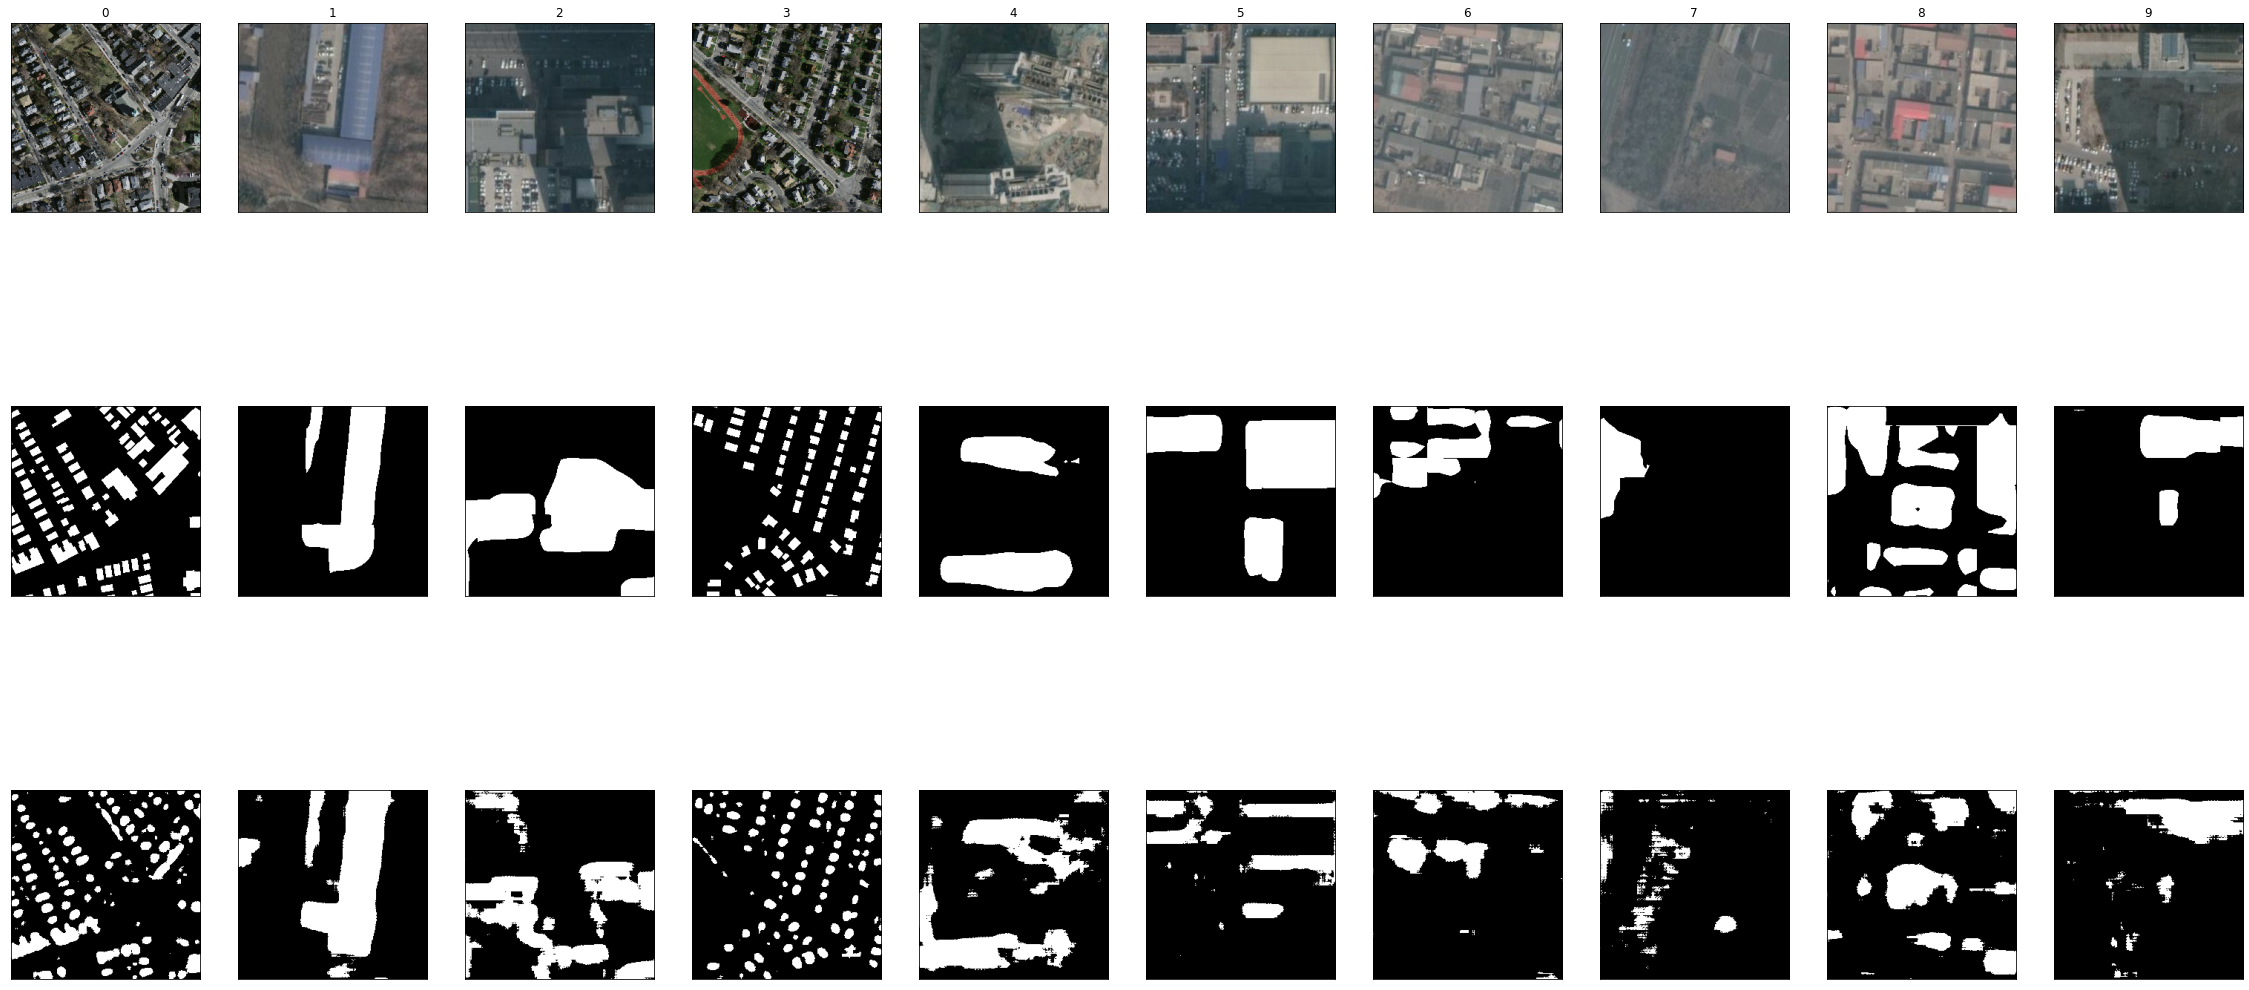

In [68]:
# plot the images

for x, y in test_dataset.take(1):
    pred=autoencoder(x,training=False)
    pred=tf.argmax(pred,axis=-1)
    n = 10
    plt.figure(figsize=(40, 20))


    for i in range(n):
        ax=plt.subplot(3, n, i + 1)
        
        plt.title(f"{i}")
        plt.imshow(tf.squeeze(x[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

    
        bx=plt.subplot(3, n, n+i + 1)
        
        plt.imshow(tf.squeeze(tf.argmax(y[i],axis=-1)))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    
        cx=plt.subplot(3, n, n+i+n + 1)
        
        plt.imshow(tf.squeeze(pred[i]))
        plt.gray()
        cx.get_xaxis().set_visible(False)
        cx.get_yaxis().set_visible(False)

        


plt.show()

In [69]:
#evalution
loss= autoencoder.evaluate(train_dataset.repeat(), steps=9)
print("Loss :", loss)

9/9 [==============================] - 7s 658ms/step - loss: 0.3290
Loss : 0.3289541006088257


# 9- Build UNet model

Note: use sub-class to create the model.

In [32]:
# Create the convolution block
class ConvBlock(tf.keras.layers.Layer):
    
    def __init__(self,filters):
        super(ConvBlock,self).__init__()
        # add conv2d to the block with BN layer
        self.Conv_1=tf.keras.layers.Conv2D(filters=filters,kernel_size=(3,3),padding='same',use_bias=False)
        self.BN_1=tf.keras.layers.BatchNormalization()
        # add conv2d to the block with BN layer
        self.Conv_2=tf.keras.layers.Conv2D(filters=filters,kernel_size=(3,3),padding='same',use_bias=False)
        self.BN_2=tf.keras.layers.BatchNormalization()
    def call(self,x):
        x=self.Conv_1(x)
        x=self.BN_1(x)
        x=tf.nn.leaky_relu(x)

        x=self.Conv_2(x)
        x=self.BN_2(x)
        x=tf.nn.leaky_relu(x)

        return x



In [33]:
# create the encoder block
class EncoderBlock(tf.keras.layers.Layer):
    def __init__(self,filters):
        super(EncoderBlock,self).__init__()
        # call the conv block 
        self.Conv_block=ConvBlock(filters)
        # add the maxpooling layer 
        self.Max_pool=tf.keras.layers.MaxPooling2D()

    def call(self,x):
        x=self.Conv_block(x)
        p=self.Max_pool(x)
      
        return x,p


In [34]:
# create the decoder block
class DecoderBlock(tf.keras.layers.Layer):
    def __init__(self,filters):
        super(DecoderBlock,self).__init__()
        # using the transpose Conv2D to upsample images 
        self.ConvTranspose=tf.keras.layers.Conv2DTranspose(filters,kernel_size=(2,2),strides=(2,2),padding='same')
        self.Conv_block=ConvBlock(filters)

    def call(self,input, skip_features):
        x=self.ConvTranspose(input)
        x=tf.keras.layers.concatenate([x,skip_features])
        x=self.Conv_block(x)
        return x



In [24]:
# Create the model 
class SemanticSegmentation(tf.keras.Model):
    def __init__(self,n_classes=2):
        super(SemanticSegmentation,self).__init__()
        # Create the encoder path
        self.encoder_block_1=EncoderBlock(32)
        self.encoder_block_2=EncoderBlock(64)
        self.encoder_block_3=EncoderBlock(128)
        self.encoder_block_4=EncoderBlock(256)
        self.encoder_block_5=EncoderBlock(512)
        # bottle neck feature maps
        self.conv_block_6=ConvBlock(1028)
        # create the decoder path
        self.decoder_block_7=DecoderBlock(512)
        self.decoder_block_8=DecoderBlock(256)
        self.decoder_block_9=DecoderBlock(128)
        self.decoder_block_10=DecoderBlock(64)
        self.decoder_block_11=DecoderBlock(32)


        # using 1x1 conv2d as output
        self.out = tf.keras.layers.Conv2D(n_classes,kernel_size=(1,1))


    def call(self,x):
        # Create the encoder path
        s1,x=self.encoder_block_1(x)
        s2,x=self.encoder_block_2(x)
        s3,x=self.encoder_block_3(x)
        s4,x=self.encoder_block_4(x)
        s5,x=self.encoder_block_5(x)

        x=self.conv_block_6(x)
        x=self.decoder_block_7(x,s5)
        x=self.decoder_block_8(x,s4)
        x=self.decoder_block_9(x,s3)
        x=self.decoder_block_10(x,s2)
        x=self.decoder_block_11(x,s1)
        x=self.out(x)
        x=tf.nn.softmax(x)

        return x
    def build_model(self,dim=(256,256,3)):
        x=tf.keras.layers.Input(dim)
        return tf.keras.Model(inputs=[x],outputs=[self.call(x)])

In [25]:
model=SemanticSegmentation()
model.build_model().summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encoder_block (EncoderBlock)   ((None, 256, 256, 3  10336       ['input_5[0][0]']                
                                2),                                                               
                                 (None, 128, 128, 3                                               
                                2))                                                               
                                                                                            

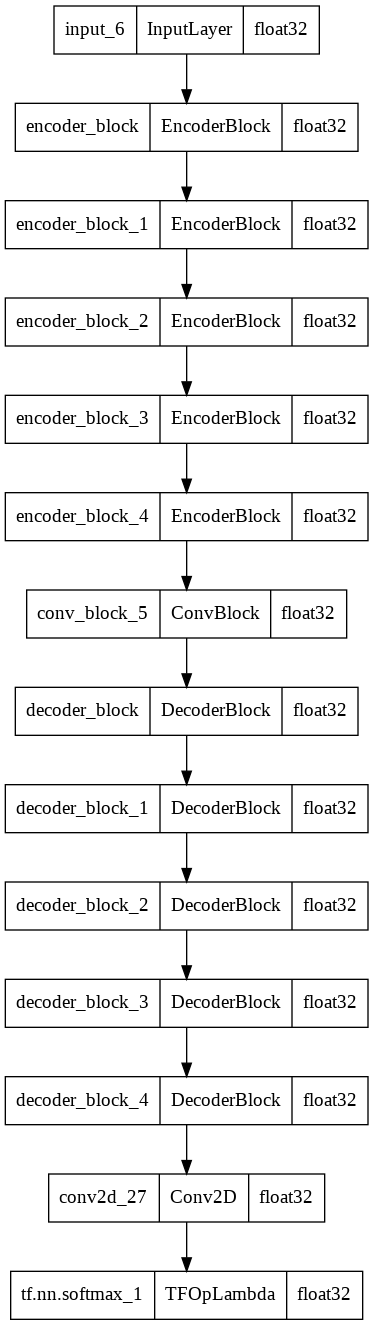

In [26]:
#plot 
tf.keras.utils.plot_model(model.build_model(),show_dtype=True)


In [27]:
#bulid the model
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['acc'])
model.fit(train_dataset,epochs=14,validation_data=test_dataset)



Epoch 1/14
170/170 [==============================] - 288s 2s/step - loss: 0.3898 - acc: 0.8372 - val_loss: 0.9403 - val_acc: 0.4197
Epoch 2/14
170/170 [==============================] - 242s 1s/step - loss: 0.3400 - acc: 0.8591 - val_loss: 0.9373 - val_acc: 0.8033
Epoch 3/14
170/170 [==============================] - 241s 1s/step - loss: 0.3235 - acc: 0.8662 - val_loss: 0.7553 - val_acc: 0.6311
Epoch 4/14
170/170 [==============================] - 242s 1s/step - loss: 0.3076 - acc: 0.8728 - val_loss: 0.3366 - val_acc: 0.8548
Epoch 5/14
170/170 [==============================] - 242s 1s/step - loss: 0.3009 - acc: 0.8756 - val_loss: 0.2983 - val_acc: 0.8781
Epoch 6/14
170/170 [==============================] - 242s 1s/step - loss: 0.2886 - acc: 0.8803 - val_loss: 0.2771 - val_acc: 0.8878
Epoch 7/14
170/170 [==============================] - 242s 1s/step - loss: 0.2772 - acc: 0.8854 - val_loss: 0.4239 - val_acc: 0.8016
Epoch 8/14
170/170 [==============================] - 242s 1s/step - 

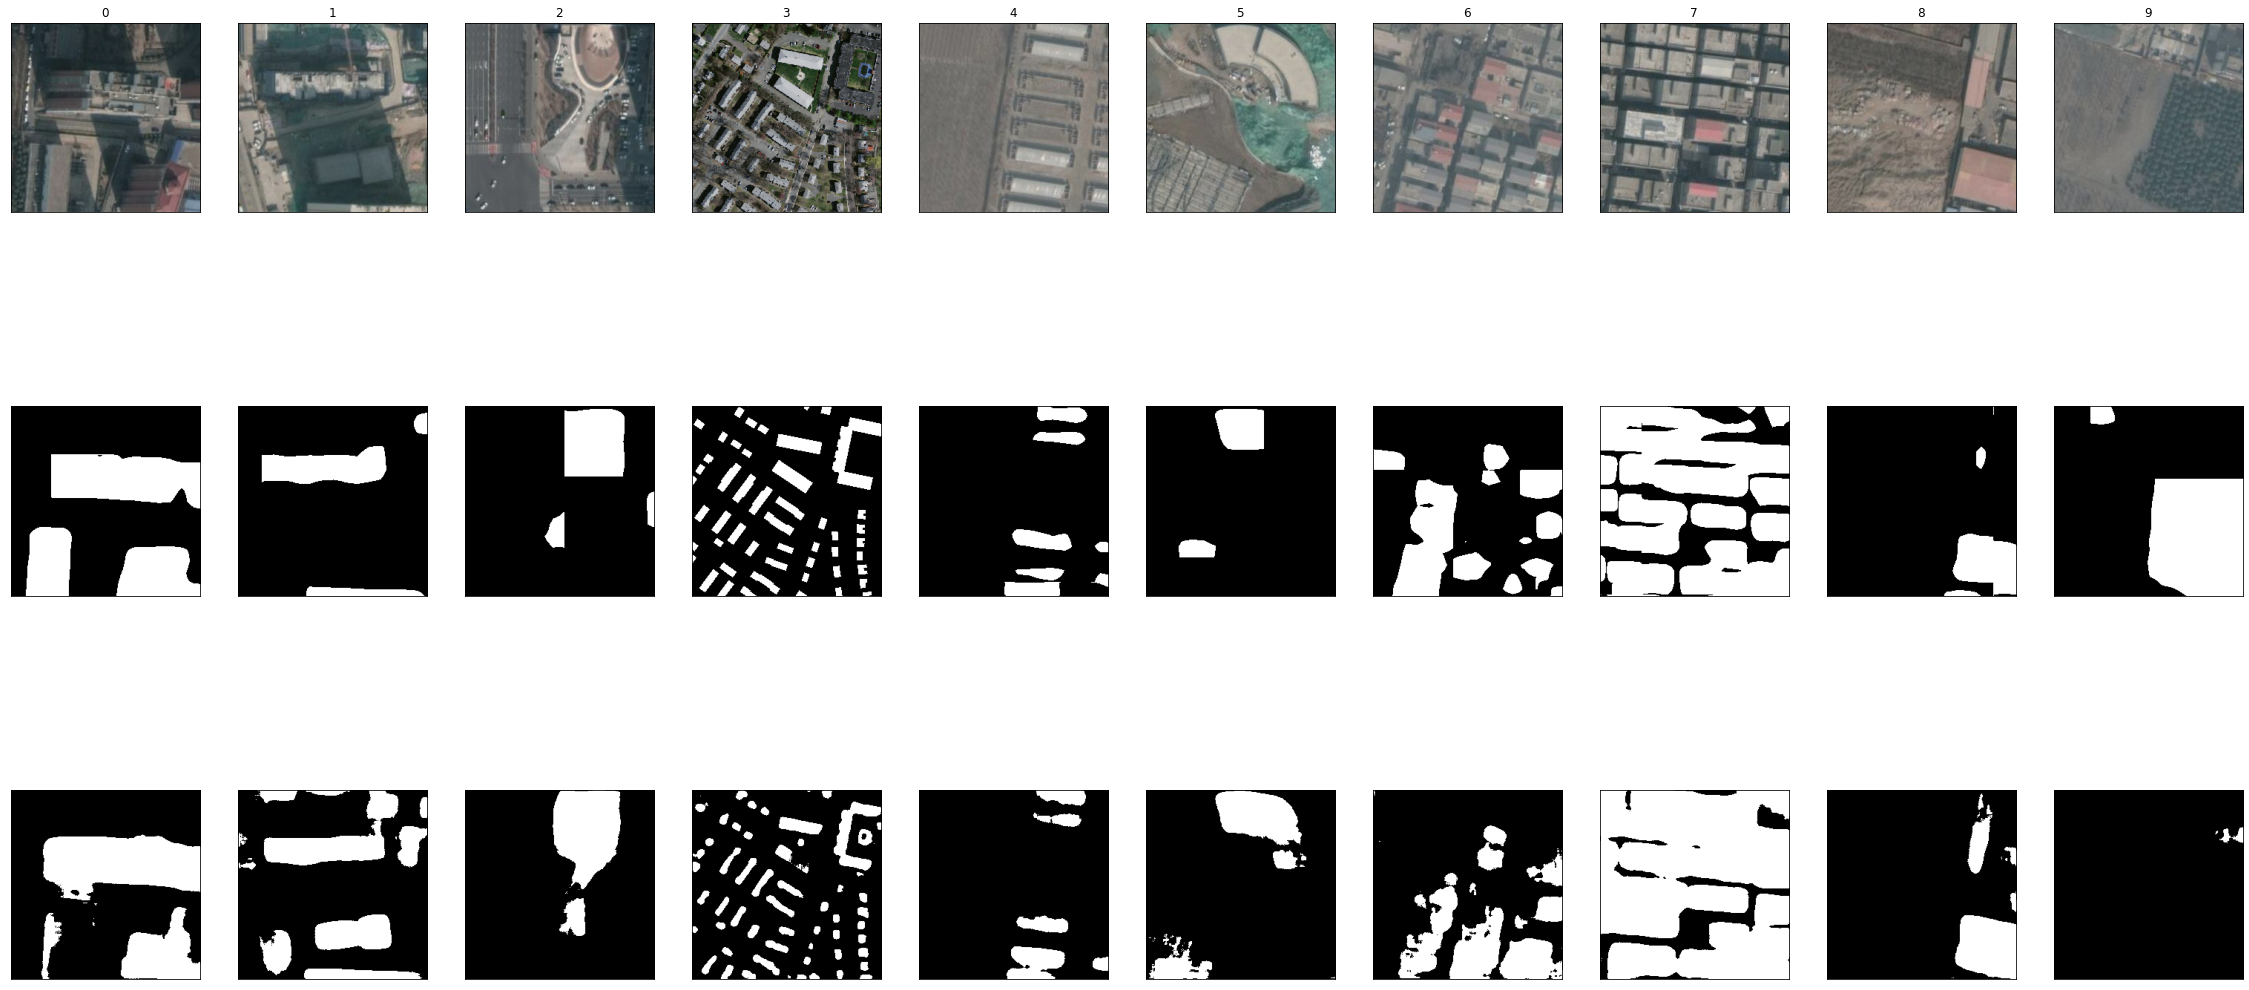

In [28]:


# plot the images

for x, y in test_dataset.take(1):
    pred=model(x,training=False)
    pred=tf.argmax(pred,axis=-1)
    n = 10
    plt.figure(figsize=(40, 20))


    for i in range(n):
        ax=plt.subplot(3, n, i + 1)
        
        plt.title(f"{i}")
        plt.imshow(tf.squeeze(x[i]))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    

    
        bx=plt.subplot(3, n, n+i + 1)
        
        plt.imshow(tf.squeeze(tf.argmax(y[i],axis=-1)))
        plt.gray()
        bx.get_xaxis().set_visible(False)
        bx.get_yaxis().set_visible(False)
    
        cx=plt.subplot(3, n, n+i+n + 1)
        
        plt.imshow(tf.squeeze(pred[i]))
        plt.gray()
        cx.get_xaxis().set_visible(False)
        cx.get_yaxis().set_visible(False)

        


plt.show()



In [30]:
#evalution
loss, accuracy = model.evaluate(train_dataset.repeat(), steps=9)
print("Loss :", loss)
print("Accuracy :", accuracy)

9/9 [==============================] - 5s 500ms/step - loss: 0.2600 - acc: 0.8908
Loss : 0.25996458530426025
Accuracy : 0.8908214569091797
